<a href="https://colab.research.google.com/github/theofarouk/IMDA/blob/main/Image_Caption_Generation_using_CNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Lab, we will develop an image caption generator using CNN and LSTM.

**1: Import the required libraries**

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

For training our model we will use Flickr8K dataset which consists of 8000 unique images. You can download this dataset from kaggle.
For this Lab, you can download it from this drive link:
https://drive.google.com/file/d/1gpV8WUG3k9LnntjdOcm6rjsxlAXxYy8X/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/CV/Flicker8k_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Flicker8k_Dataset")

**2. Load the descriptions**
The format of our file is image and caption separated by a newline (“\n”) i.e it consists of the name of the image followed by a space and the description of the image in CSV format. Here we need to map the image to its descriptions by storing them in a dictionary.

In [ ]:
images_directory = '/content/Flicker8k_Dataset/flickr8k/images/'
captions_path = '/content/Flicker8k_Dataset/flickr8k/captions.txt'
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

**3. Cleaning the text**
One of the main steps in NLP is to remove noise so that the machine can detect the patterns easily in the text. Noise will be present in the form of special characters such as hashtags, punctuation and numbers. All of which are difficult for computers to understand if they are present in the text. So we need to remove these for better results. Additionally you can also remove stop words and perform Stemming and Lemmatization by using NLTK library.

In [ ]:
import re
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

**4. Cleaning the captions**
We further process the captions by adding start and end tokens to define the sentence boundaries.

In [ ]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

**5. Load some images with captions**
Here we need to map the images in the training set to their corresponding descriptions which are present in our descriptions variable. Create a list of names of all training images and then create an empty dictionary and map the images to their descriptions using image name as key and a list of descriptions as its value. while mapping the descriptions add unique words at the beginning and end to identify the start and end of the sentence.

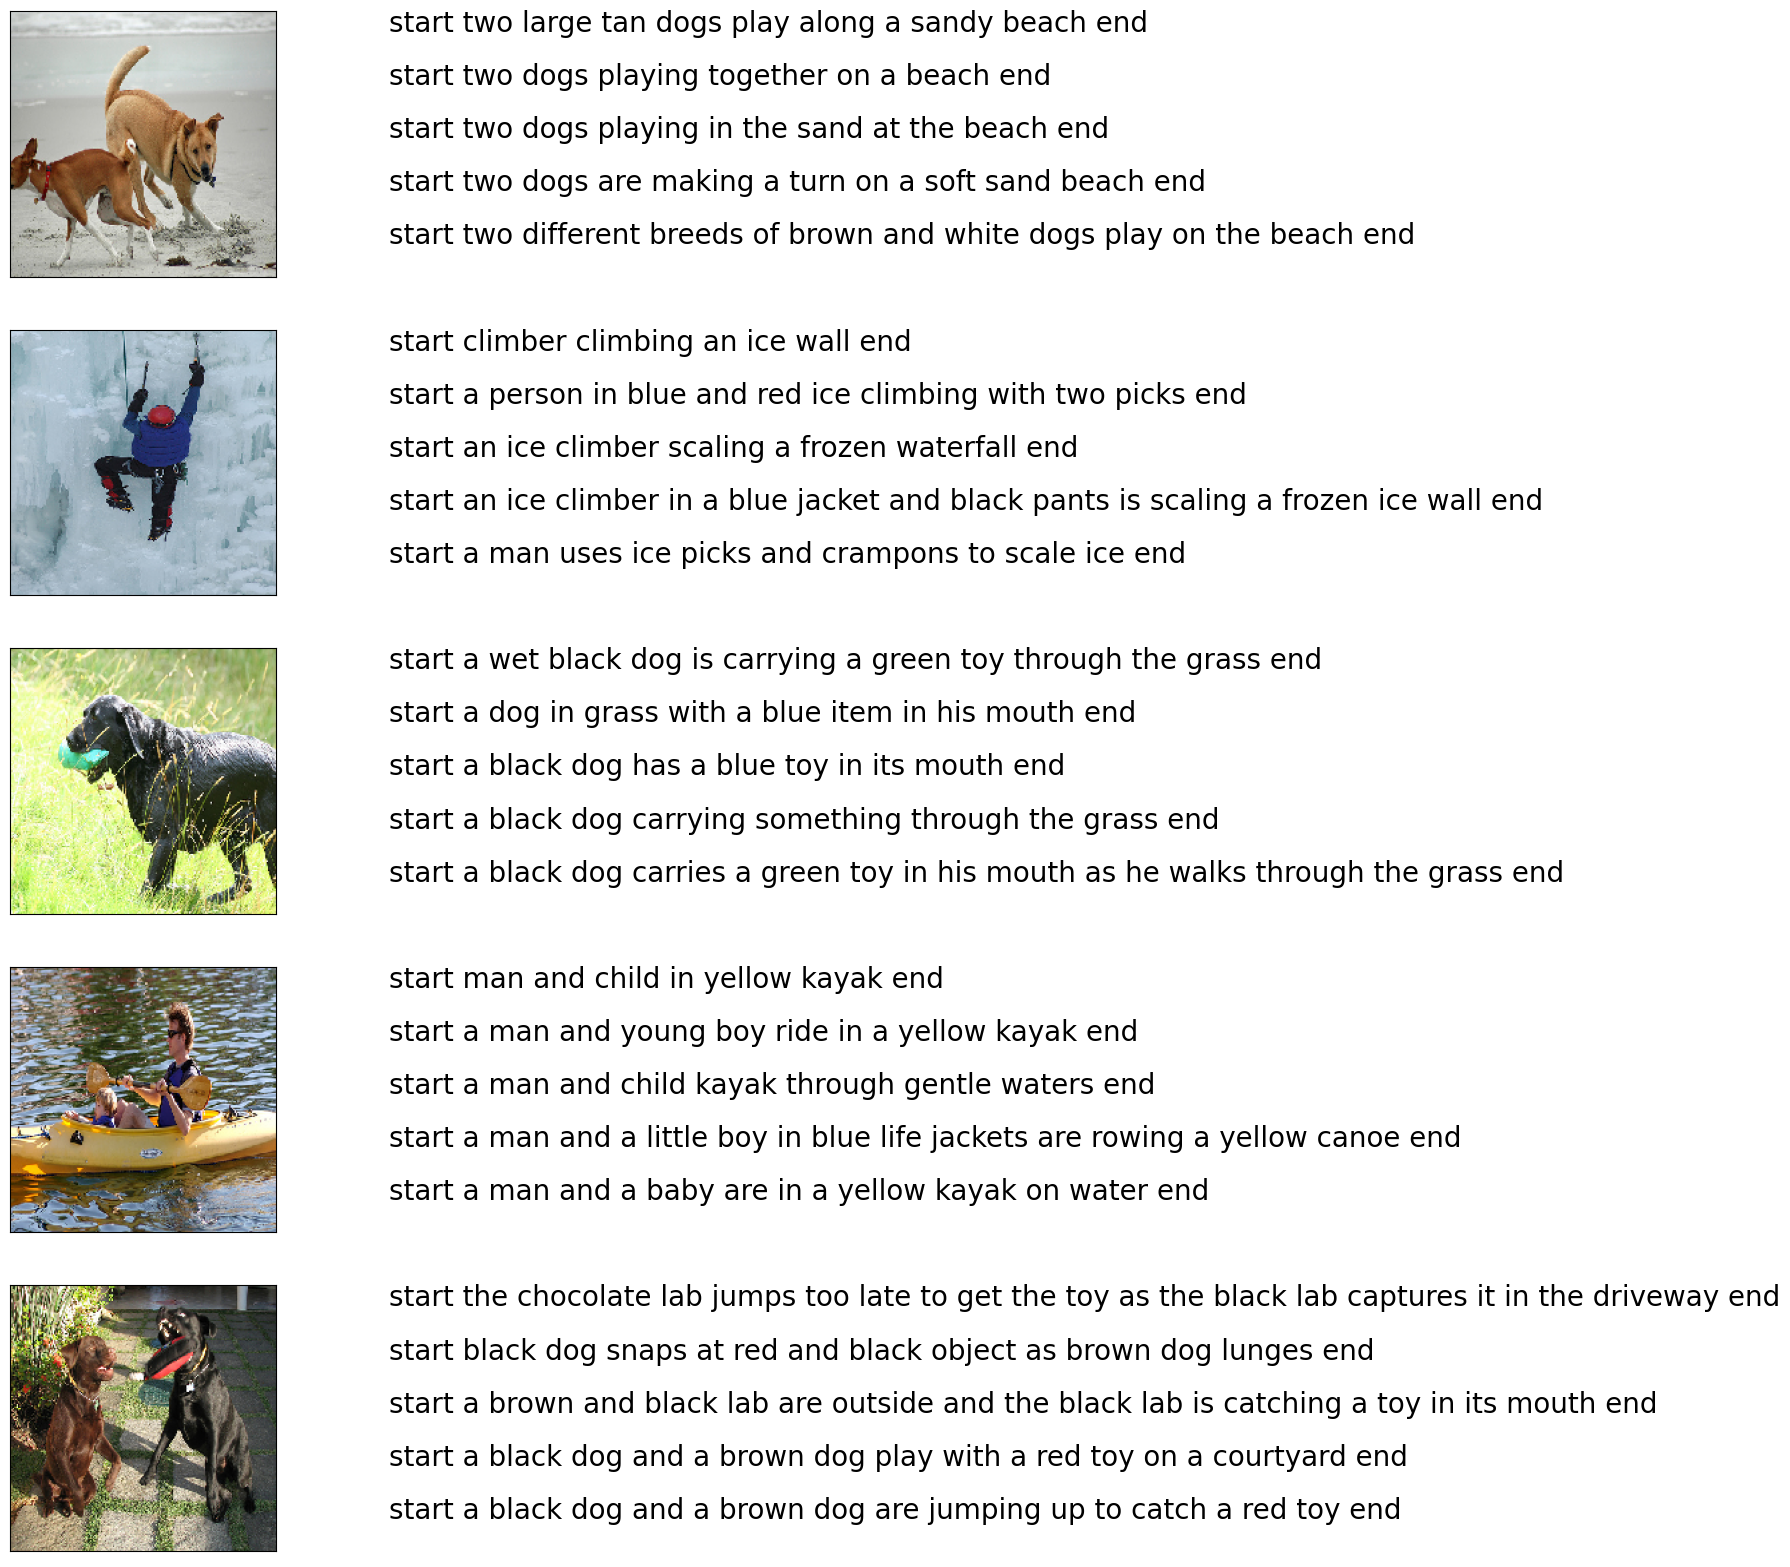

In [ ]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]

    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(captions_IDs, 5)

Analyze the length of captions to determine an optimal sequence length.

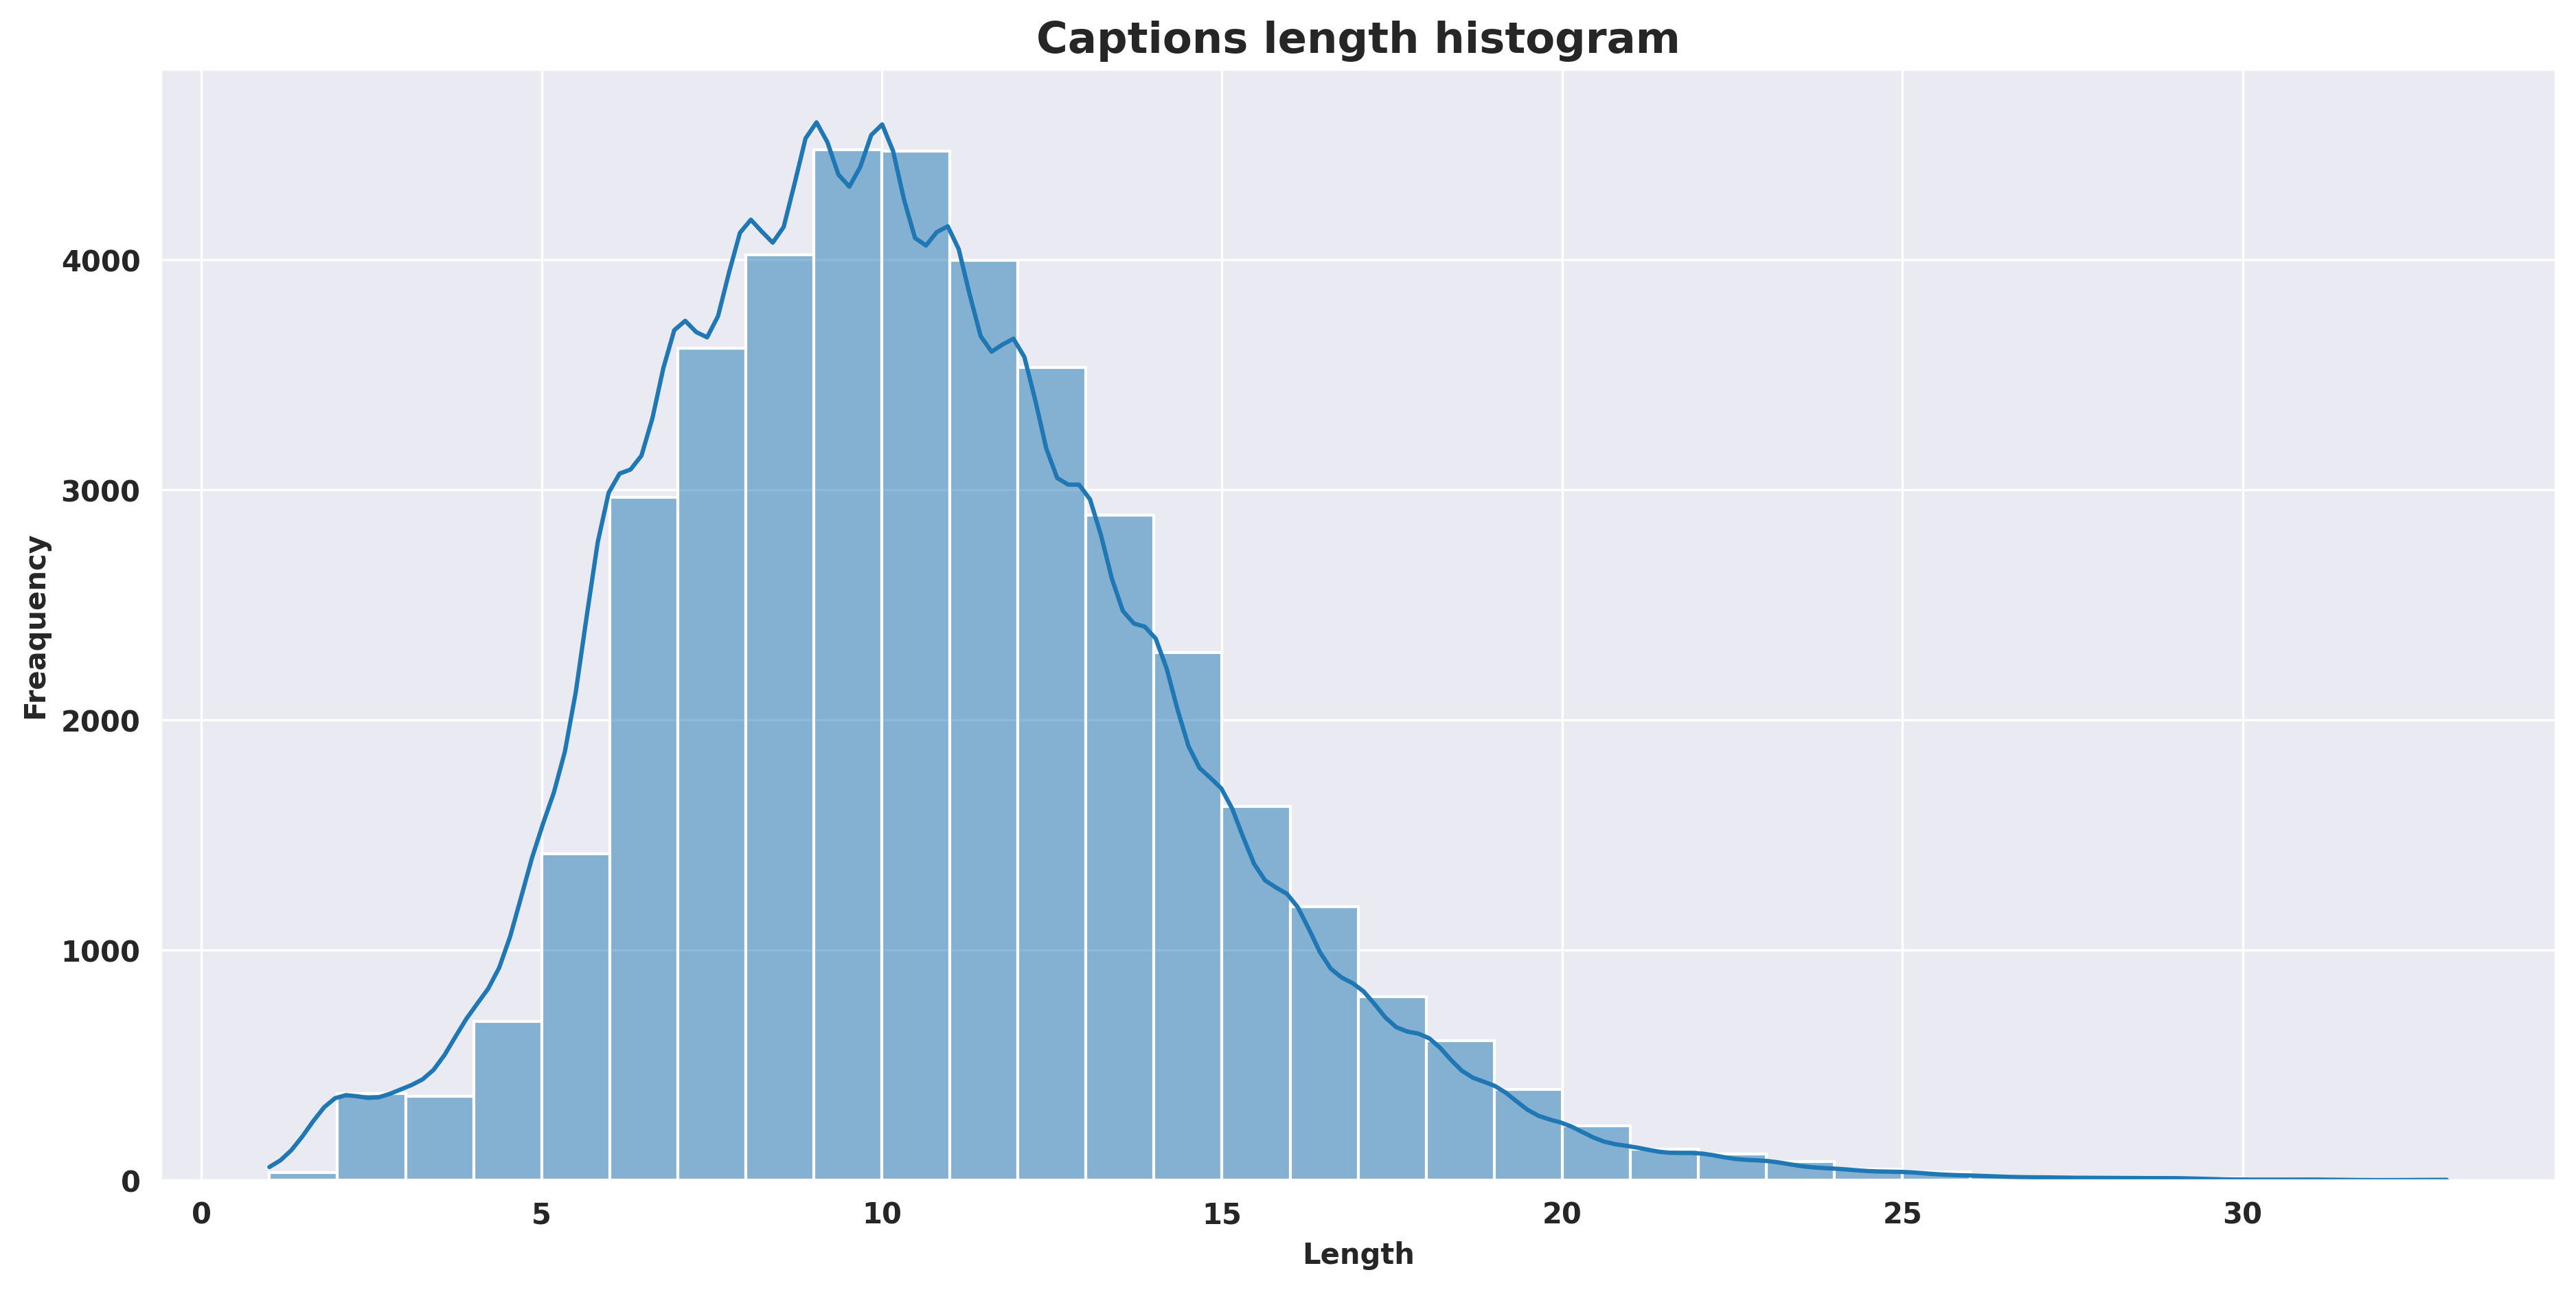

In [ ]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)

**Tokenizing the vocabulary**
We will use Keras Tokenizer to convert text data into numerical sequences.

In [ ]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

Splitting the data into train, validation and test sets

In [ ]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)
    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1015584366_dfcec3c85a.jpg\tstart a black dog leaps over a log end\n',
 '1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 6877.0,
 1092.0,
 122.0)

**Extract the feature vector from all images**

we use the pre-trained "InceptionV3" model. We need to remove the last classification layer to get the (2048, ) dimensional feature vector from InceptionV3 model.

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting Image Features for Training, Validation and Testing

In [ ]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    else:
        print('Unknown image ID !')

pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

**Creating a Data Generator for Model Training**

A data generator, which yields batches of image features and corresponding tokenized captions, improves memory efficiency by processing data dynamically rather than loading everything into memory at once.

In [ ]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            # 👇 use tuples here
            yield (np.array(X_images), np.array(X_captions)), np.array(y)

max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

cnn_output_dim = inception_v3_model.output_shape[1] # 2048

batch_size_train = 270
batch_size_val = 150

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [ ]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)

    while True:
        np.random.shuffle(captions)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []

            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences(
                        [in_seq],
                        maxlen=max_caption_length,
                        padding='post',    # 👈 here
                        truncating='post'  # 👈 optional
                    )[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            X_images = np.array(X_images, dtype='float32')
            X_captions = np.array(X_captions, dtype='int32')
            y = np.array(y, dtype='float32')

            yield (X_images, X_captions), y

max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

cnn_output_dim = inception_v3_model.output_shape[1] # 2048

batch_size_train = 270
batch_size_val = 150

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)


**Building the Image Captioning Model**

The model consists of:

- A CNN-based Image Feature Extractor: The input image feature vector (2048-dimensional) is normalized using Batch Normalization. A Dense layer transforms it into a 256-dimensional vector to match the LSTM output size.
- LSTM-based Decoder: The tokenized captions are passed through an Embedding layer, mapping words to dense vector representations. An LSTM layer processes the embedded sequence to generate a feature representation.
- Decoder and Final Prediction: The processed image and text features are combined using an addition operation. A Dense layer refines the representation before making the final word prediction using a softmax activation function

In [ ]:
# vocab size
vocab_size = max(tokenizer.word_index.values()) + 1

def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = BatchNormalization()(fe2)

    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
caption_model.summary()


Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 34, 256)   │  2,198,016 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 34)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256)       │    525,312 │ embedding_4[0][0… │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     65,792 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8586)      │  2,206,602 │ dense_9[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

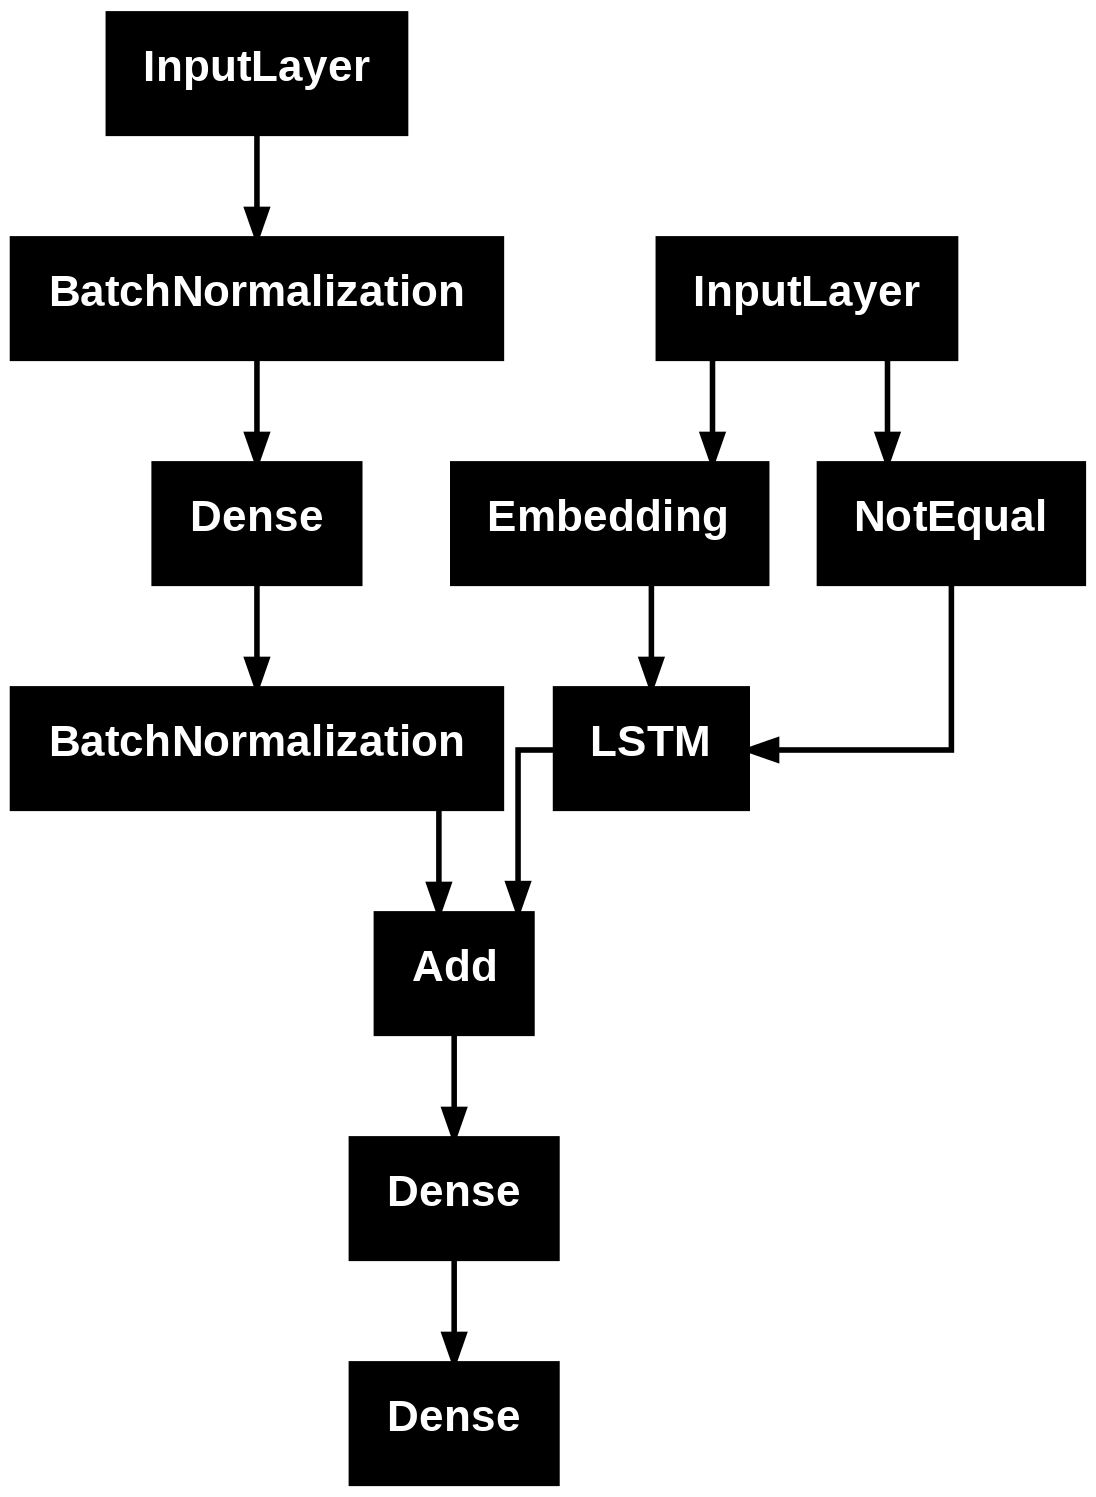

In [ ]:
plot_model(caption_model)

**Training the Model**

In [ ]:
import math

def lr_scheduler(epoch, lr):
    return lr * math.exp(-0.6)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_data_generator,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 50s 377ms/step - loss: 5.0031 - val_loss: 3.5163 - learning_rate: 0.0055
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 82s 647ms/step - loss: 3.0089 - val_loss: 3.1813 - learning_rate: 0.0030
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 44s 350ms/step - loss: 2.5684 - val_loss: 3.1538 - learning_rate: 0.0017
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 46s 362ms/step - loss: 2.3313 - val_loss: 3.1790 - learning_rate: 9.0718e-04
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 44s 349ms/step - loss: 2.1768 - val_loss: 3.2217 - learning_rate: 4.9787e-04
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 343ms/step - loss: 2.0920 - val_loss: 3.2320 - learning_rate: 2.7324e-04


**Visualizing Training and Validation Loss**

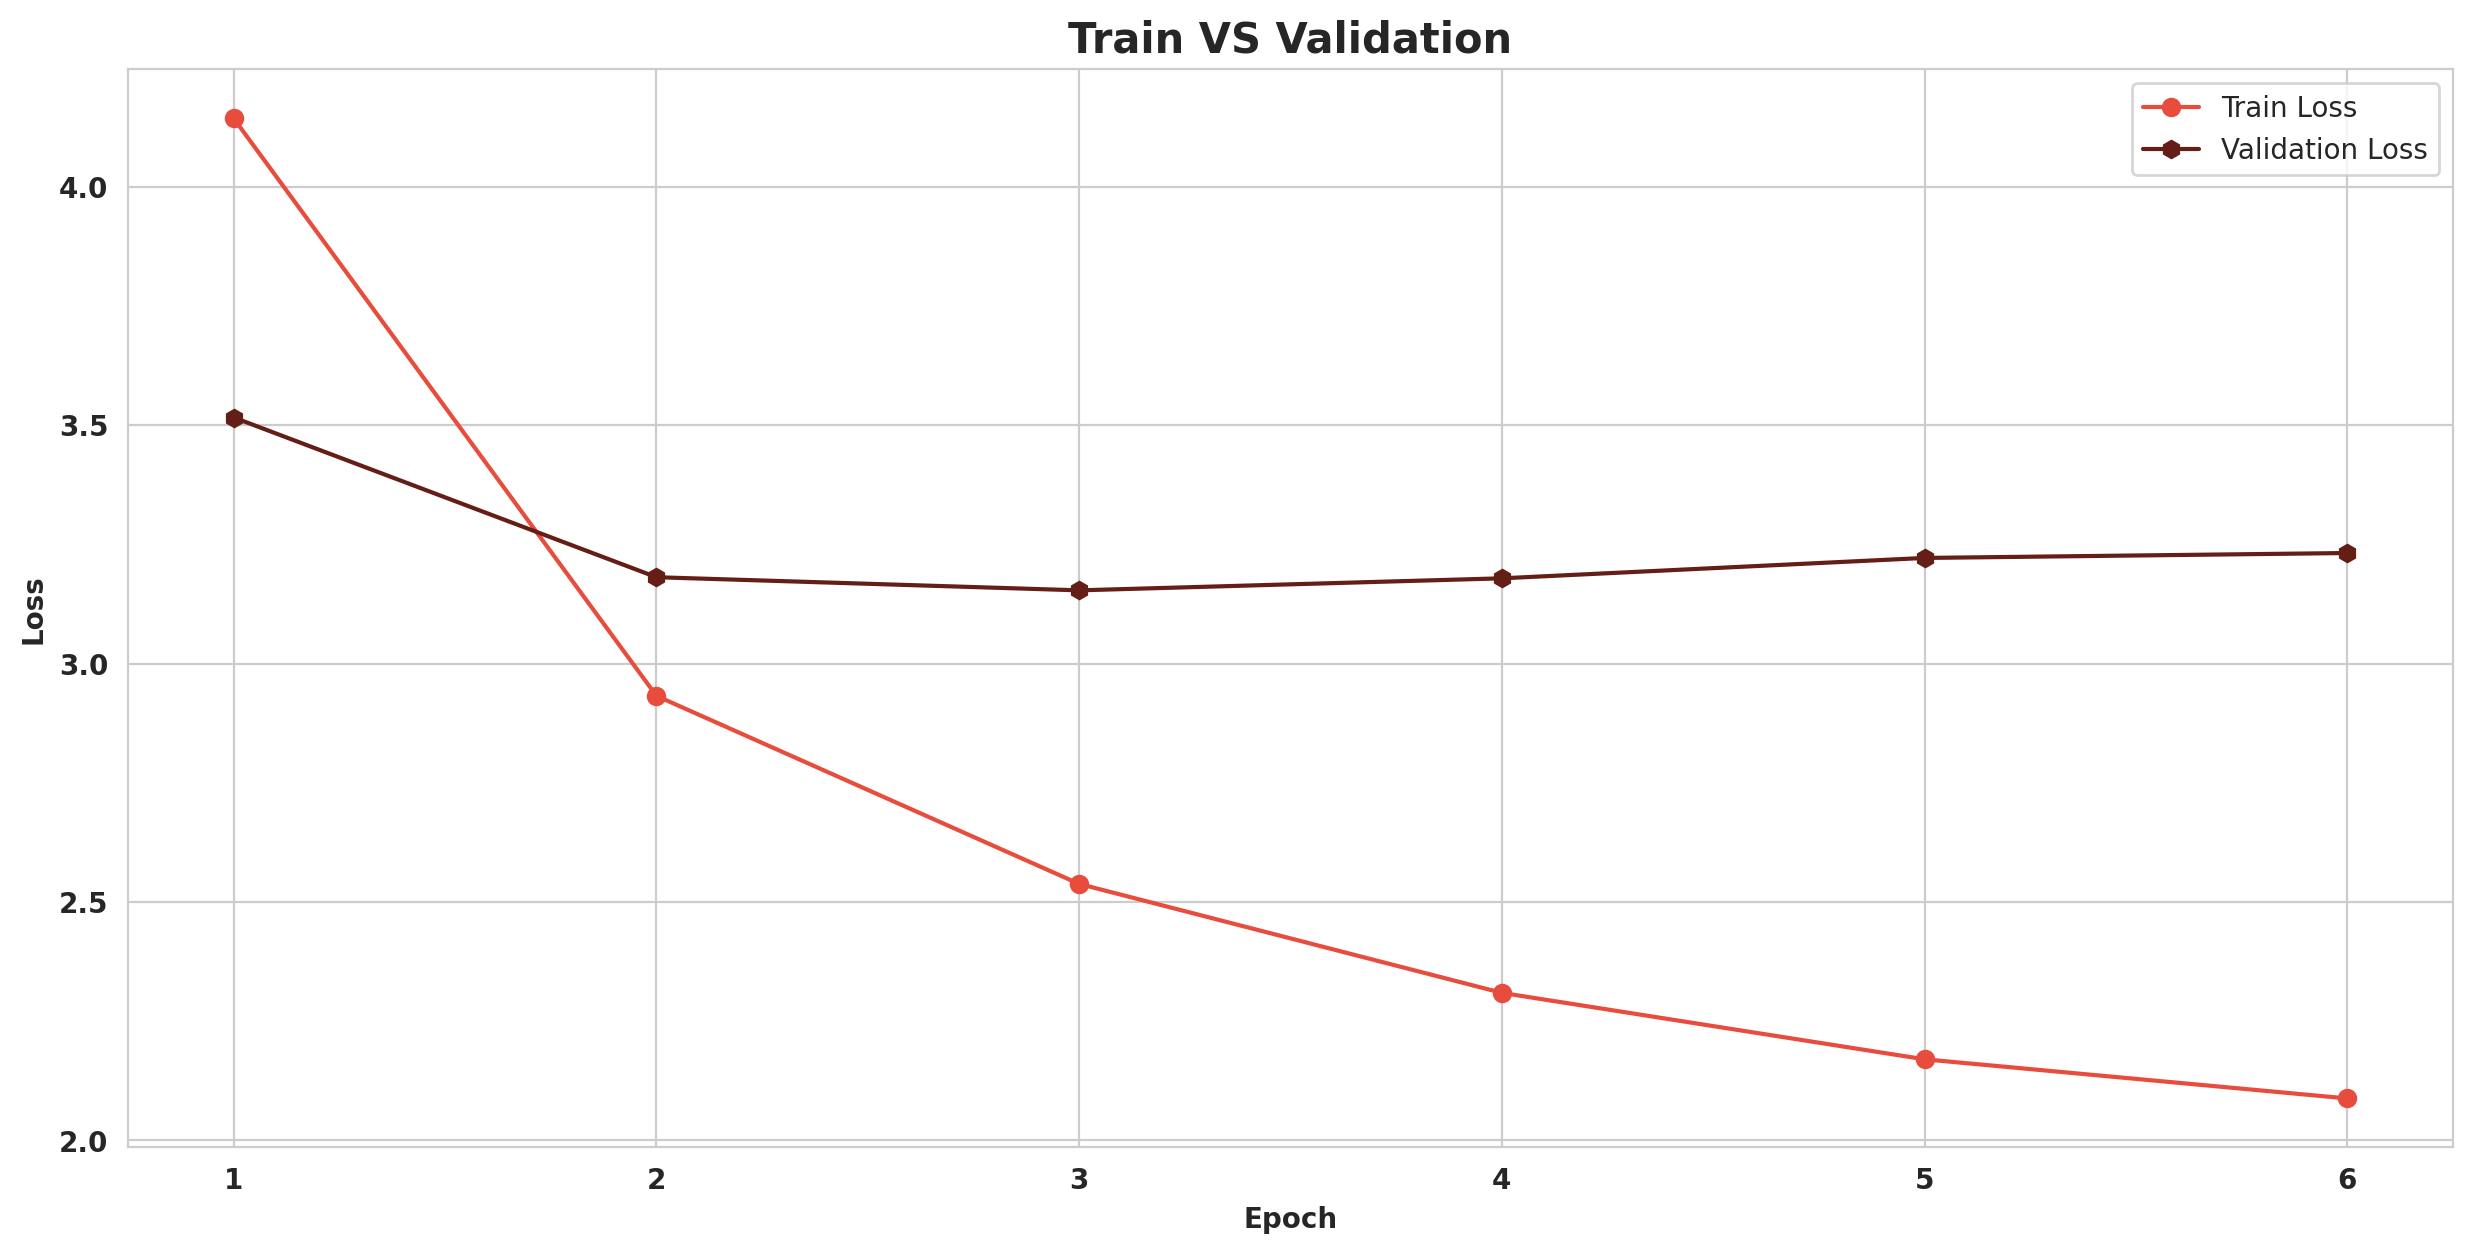

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

**Generating Captions Using Greedy Search**

A greedy search algorithm generates captions by predicting one word at a time. The model selects the word with the highest probability at each step until the end token is reached.

In [ ]:
def greedy_generator(image_features):
    in_text = 'start'
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        sequence = pad_sequences(
            [sequence],
            maxlen=max_caption_length,
            padding='post',
            truncating='post'
        )

        # sequence.shape == (1, max_caption_length), OK for model
        prediction = caption_model.predict(
            [image_features.reshape(1, cnn_output_dim), sequence],
            verbose=0
        )

        idx = np.argmax(prediction[0])

        # safety: if idx not in vocab, stop
        if idx == 0 or idx not in tokenizer.index_word:
            break

        word = tokenizer.index_word[idx]
        in_text += ' ' + word

        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text


**Generating Captions Using Beam Search**

A beam search generates captions by exploring multiple possible sequences at each step. This method selects the top K probable sequences.

In [ ]:
def beam_search_generator(image_features, K_beams=3, log=False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]

    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Padding must match training!
            sequence = pad_sequences(
                [s[0]],
                maxlen=max_caption_length,
                padding='post',
                truncating='post'
            ).reshape((1, max_caption_length))

            preds = caption_model.predict(
                [image_features.reshape(1, cnn_output_dim), sequence],
                verbose=0
            )

            word_preds = np.argsort(preds[0])[-K_beams:]

            for w in word_preds:
                next_seq = s[0][:]  # copy sequence
                next_seq.append(w)

                prob = s[1]
                if log:
                    prob += np.log(preds[0][w] + 1e-10)
                else:
                    prob += preds[0][w]

                temp.append([next_seq, prob])

        # Keep top-K
        start_word = sorted(temp, key=lambda x: x[1])
        start_word = start_word[-K_beams:]

    best_seq = start_word[-1][0]

    # Convert tokens → words
    caption_words = []
    for idx in best_seq:
        word = tokenizer.index_word.get(idx, None)
        if word is None:
            continue
        if word == 'end':
            break
        caption_words.append(word)

    # Remove 'start'
    if len(caption_words) > 0 and caption_words[0] == 'start':
        caption_words = caption_words[1:]

    return ' '.join(caption_words)


In [ ]:
image_id = next(iter(test_image_features))
print(beam_search_generator(test_image_features[image_id], K_beams=3))

a baseball player in a baseball uniform is playing cricket


**BLEU Score**

Compute the BLEU (Bilingual Evaluation Understudy) score for evaluating the quality of text translations by comparing them to one or more reference translations.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def BLEU_score(actual, greedy, beam_search):
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def BLEU_score(references, greedy_caps, beam_caps):
    smoothie = SmoothingFunction().method1

    bleu_greedy = corpus_bleu(
        [[ref.split()] for ref in references],
        [hyp.split() for hyp in greedy_caps],
        smoothing_function=smoothie
    )

    bleu_beam = corpus_bleu(
        [[ref.split()] for ref in references],
        [hyp.split() for hyp in beam_caps],
        smoothing_function=smoothie
    )

    return [
        f"Greedy BLEU: {bleu_greedy:.3f}",
        f'Greedy: {greedy_caps[0]}'
        f"Beam BLEU:   {bleu_beam:.3f}",
        f'Beam Search:  {beam_caps[0]}'
    ]


Generate Captions for all Test Images using the greedy search method, and visualize results

In [ ]:
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id, feat in test_image_features.items():
    cap = greedy_generator(feat)
    generated_captions[image_id] = cap
    pbar.update(1)
pbar.close()

  0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
test_actual_captions = {}

for line in test_captions:   # <-- list of captions
    img, cap = line.split('\t')
    cap = cap.strip()
    if img not in test_actual_captions:
        test_actual_captions[img] = []
    test_actual_captions[img].append(cap)

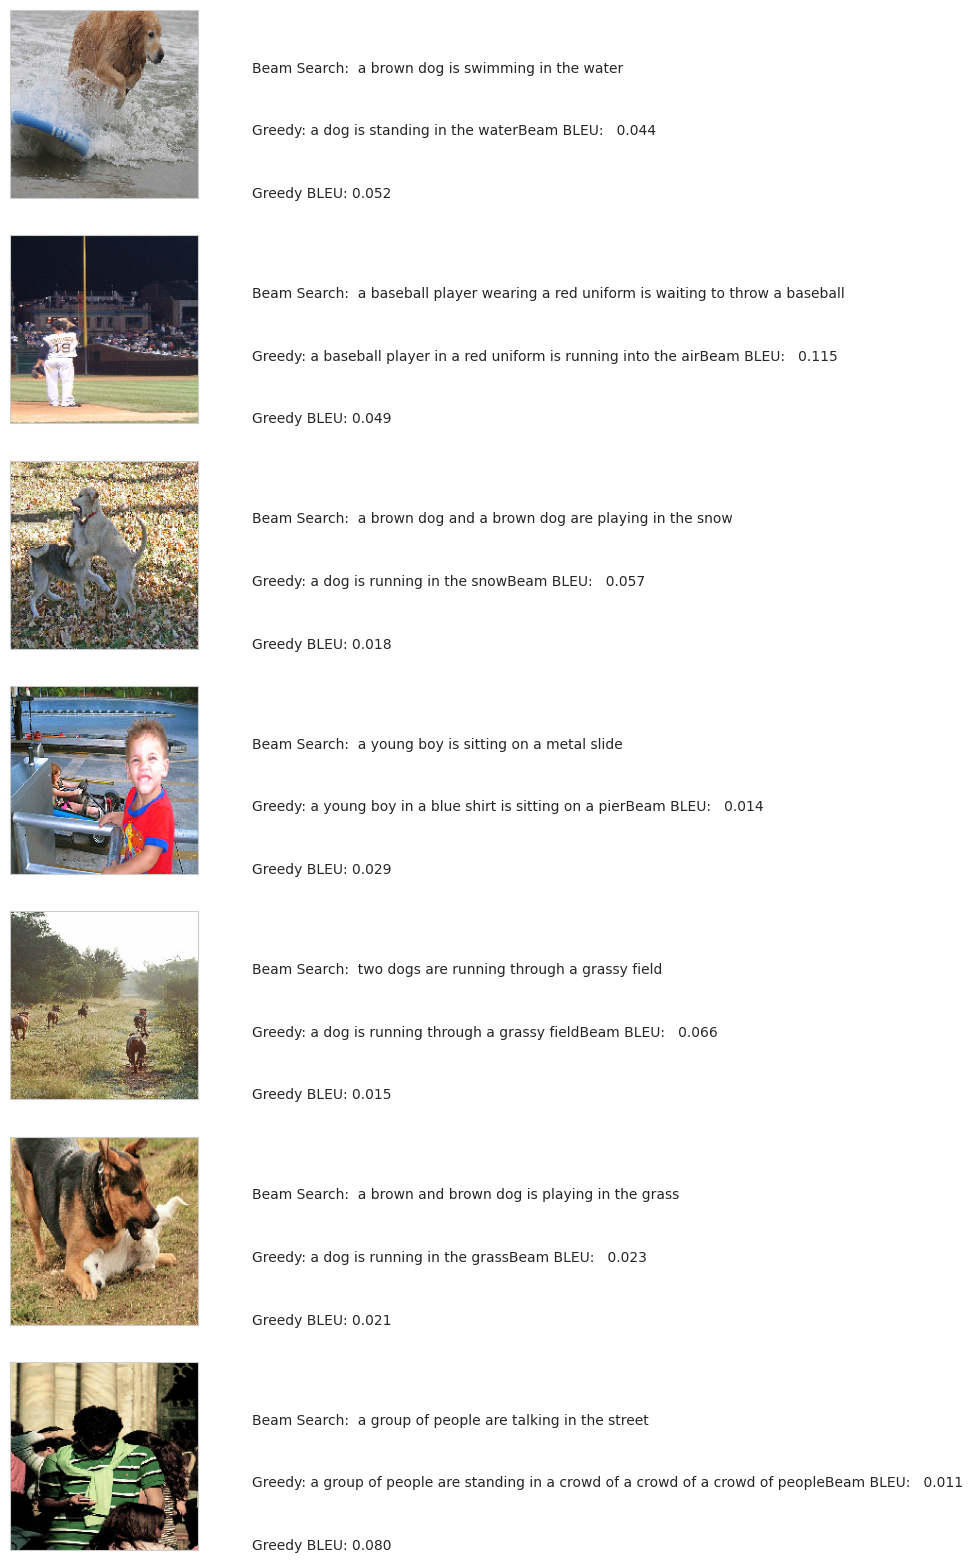

In [ ]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys())
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    count = 1
    fig = plt.figure(figsize=(6,20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap]
        actual_cap = [x.replace(" end", "") for x in actual_cap]

        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])

        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))

        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

# Add attention to the LSTM decoder

Because attention needs spatial features (many vectors per image, not just one 2048-D vector), we’ll:

*   Change the feature extractor to keep the last conv map of InceptionV3 (8×8×2048 → 64×2048).
*   Add a BahdanauAttention layer.
*   Build a new build_model_with_attention(...) that uses this attention.
*   Train it with (almost) the same generator as in your notebook (just that the features will have an extra dimension).

**1. Modify feature extraction (keep spatial features)**

In your notebook, replace the image processing and feature extraction by this bloc:

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

# Ici on garde les features CONV, pas le global pooling
base_cnn = InceptionV3(weights='imagenet', include_top=False,
                       input_shape=(299, 299, 3))
# sortie: (batch, 8, 8, 2048)
inception_v3_model = base_cnn  # on peut l'utiliser directement

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    # features: (1, 8, 8, 2048)
    features = model.predict(img, verbose=0)
    # reshape en (num_pixels, feature_dim), ici (64, 2048)
    features = features.reshape((-1, features.shape[-1]))
    return features  # shape: (num_pixels, feature_dim)


You then need to regenerate all your image_features (train/val/test), because their shape changes (before (2048), now (64, 2048)).

After loading these features, you can automatically retrieve the dimensions:

In [ ]:
# Exemple: récupérer la forme (num_pixels, feature_dim)
sample_feats = next(iter(train_image_features.values()))
num_pixels, cnn_feature_dim = sample_feats.shape
print("num_pixels:", num_pixels, "feature_dim:", cnn_feature_dim)


**2. Define Bahdanau's attention layer**

Add this code to a new cell:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class BahdanauAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden_state):
        """
        features: (batch_size, num_pixels, feature_dim)
        hidden_state: (batch_size, dec_units)
        """
        # hidden_state -> (batch_size, 1, dec_units)
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

        # score: (batch_size, num_pixels, units)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights: (batch_size, num_pixels, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector: somme pondérée des features
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, feature_dim)

        return context_vector, attention_weights


**3. New model with attention in the decoder**

We start with the existing model and augment it with attention.
replace your **build_model** fonction with a version that takes (num_pixels, cnn_feature_dim) as input.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, BatchNormalization, add, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model_with_attention(vocab_size, max_caption_length,
                               num_pixels, cnn_feature_dim,
                               attn_units=256, dec_units=256):

    # ----- Branche image: features spatiales -----
    # shape: (batch, num_pixels, cnn_feature_dim) ex: (batch, 64, 2048)
    input_image = Input(shape=(num_pixels, cnn_feature_dim), name='Features_Input')

    # On normalise + projette les features (opère sur chaque pixel)
    fe1 = BatchNormalization(name="img_bn")(input_image)
    fe2 = Dense(256, activation='relu', name="img_dense")(fe1)
    # fe2: (batch, num_pixels, 256)

    # ----- Branche texte: séquence -----
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True, name="word_embedding")(input_caption)
    # LSTM renvoie le dernier état caché -> (batch, dec_units)
    se2 = LSTM(dec_units, name="caption_lstm")(se1)

    # ----- Attention: fe2 (encoder), se2 (hidden état du décodeur) -----
    attention = BahdanauAttention(attn_units, name="bahdanau_attention")
    context_vector, attention_weights = attention(fe2, se2)
    # context_vector: (batch, 256)

    # ----- Fusion contexte + hidden -----
    decoder_input = Concatenate(axis=-1, name="concat_context_hidden")([context_vector, se2])
    decoder2 = Dense(256, activation='relu', name="decoder_dense")(decoder_input)

    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs,
                  name='Image_Captioning_with_Attention')
    return model

# Créer le modèle avec attention
caption_model = build_model_with_attention(
    vocab_size=vocab_size,
    max_caption_length=max_caption_length,
    num_pixels=num_pixels,
    cnn_feature_dim=cnn_feature_dim,
    attn_units=256,
    dec_units=256
)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
caption_model.summary()


Note: We're keeping the same output format (softmax on vocab_size), so your generator and training loop remain almost identical.

**4. Generator & Training**

You already have a data_generator that returns something like:

yield(np.array(X_images), np.array(X_captions)), np.array(y)

and now X_images contains shape features (num_pixels, cnn_feature_dim) (thanks to the new extract_image_features), you can keep the exact same generator.

So the training part remains:

In [ ]:
history = caption_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_data_generator,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)
